# Computer Vision 2022 Assignment 2: Image matching and retrieval

In this assignment, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the assignment:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

This assignment will have a minimum hurdle of 40%. You will fail if you can not reach the minimum hurdle.

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'
    # Or
    jupyter nbconvert Assignment2.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

**Please do try this ccommond early before the last day! As the commend may be a little bit difference depending on your computer and the environment.**

This will also remove the preamble text from each question. We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

This being the second assignment, we have provided less strict direction this time and you have more flexibility to choose how you answer each question. However you still need to ensure the outputs and report are clear and easy to read. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. Within each category, there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Mounted at /content/drive/


In [2]:
def draw_outline(ref, query, model, title):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img, 'gray'), plt.title(title), plt.show()

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask, title):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.title(title), plt.show()

# My Functions

In [3]:
def select_data(left_idx, right_idx, path):
    ###Returns array of tuples: [image, image_idx] 
    images = []
    for i in range(left_idx, right_idx):
        cur_idx = str(i).zfill(3)
        images.append(cv2.imread(path + cur_idx + '.jpg', cv2.IMREAD_GRAYSCALE))

    return images

def RANSAC_method(kp1, kp2, good):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return M, mask

def compute_descriptors(img, n_features = None):
    if n_features == None:
      orb = cv2.ORB_create()
    else:
      orb = cv2.ORB_create(n_features)

    kp_img = orb.detect(img, None)
    kp_img, des_img = orb.compute(img, kp_img)
    return kp_img, des_img

def match_features(ref, query, ratio):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(ref, query, k=2)

    good = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good.append(m)
        
    return good

def plot_figure(img, title):
  fig = plt.figure()
  plt.imshow(img)
  plt.title(title)
  plt.show()
  return


# Load Datasets

In [4]:
books_ref_path = "/content/drive/MyDrive/a2/A2_smvs/book_covers/Reference/"
books_query_path = "/content/drive/MyDrive/a2/A2_smvs/book_covers/Query/"

museum_ref_path = "/content/drive/MyDrive/a2/A2_smvs/museum_paintings/Reference/"
museum_query_path = "/content/drive/MyDrive/a2/A2_smvs/museum_paintings/Query/"

landmarks_ref_path = "/content/drive/MyDrive/a2/A2_smvs/landmarks/Reference/"
landmarks_query_path = "/content/drive/MyDrive/a2/A2_smvs/landmarks/Query/"

books_ref = select_data(1, 102, books_ref_path)
books_query = select_data(1, 102, books_query_path)
books_labels = list(range(1, 102))

landmarks_ref = select_data(1, 101, landmarks_ref_path)
landmarks_query = select_data(1, 101, landmarks_query_path)
landmarks_labels = list(range(1, 101))

museum_ref = select_data(1, 92, museum_ref_path)
museum_query = select_data(1, 92, museum_query_path)
museum_labels = list(range(1, 92))

# Question 1: Matching an object in a pair of images (45%)

In this question, the aim is to accurately locate a reference object in a query image, for example:


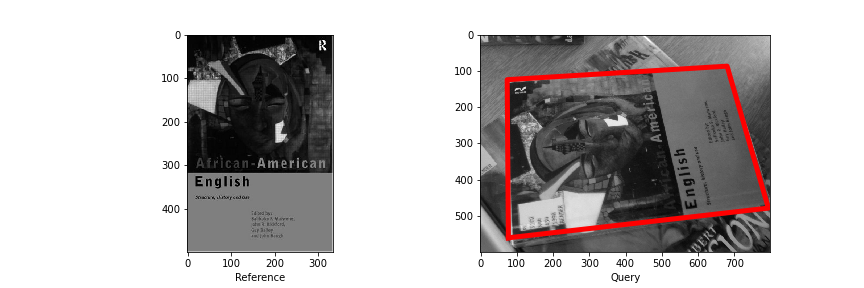

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 4) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 4, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


***Your explanation of what you have done, and your results, here***

[1] Load first image pair from book covers

In [ ]:
img1 = books_ref[0] #Reference image
img2 = books_query[0] #Query image

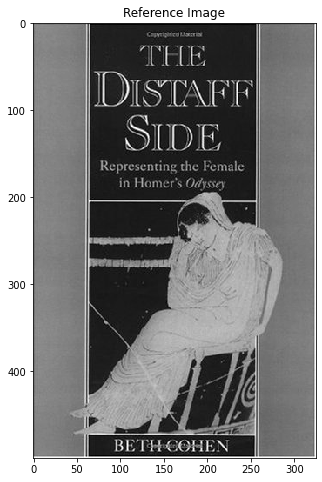

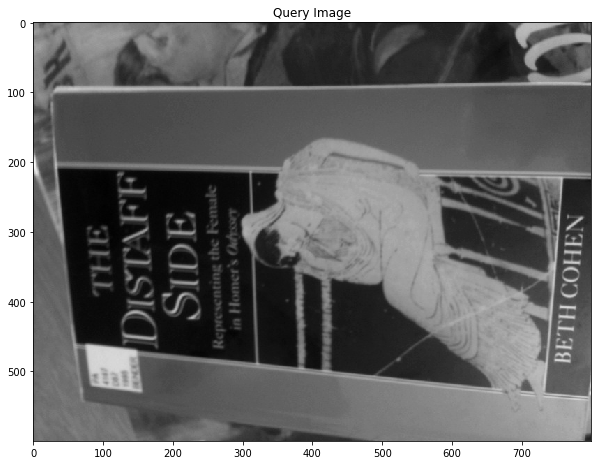

In [ ]:
# Draw images
plot_figure(img1, "Reference Image")
plot_figure(img2, "Query Image")

[2] Detect Features

In [ ]:
kp1, des1 = compute_descriptors(img1)
kp2, des2 = compute_descriptors(img2)

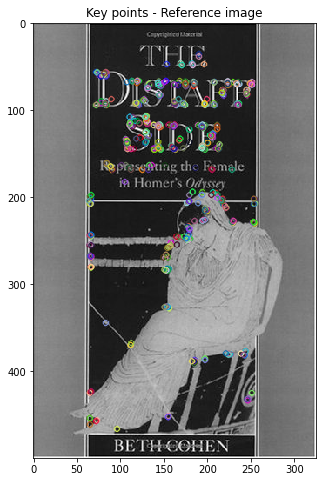

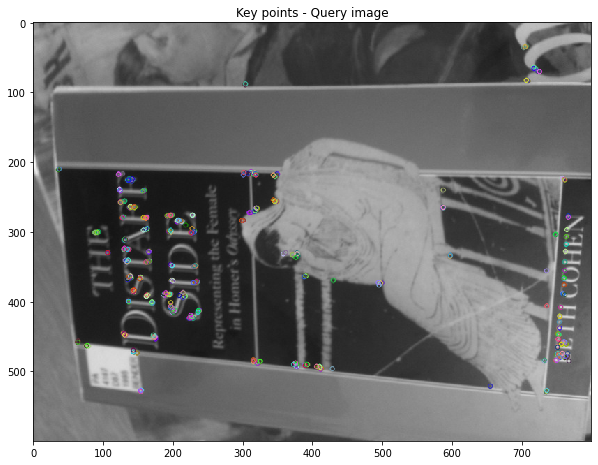

In [ ]:
# Draw keypoints
img1_draw_kp = cv2.drawKeypoints(img1, kp1, np.array([]))
img2_draw_kp = cv2.drawKeypoints(img2, kp2, np.array([]))

plot_figure(img1_draw_kp, "Key points - Reference image")
plot_figure(img2_draw_kp, "Key points - Query image")

[3] Match Features

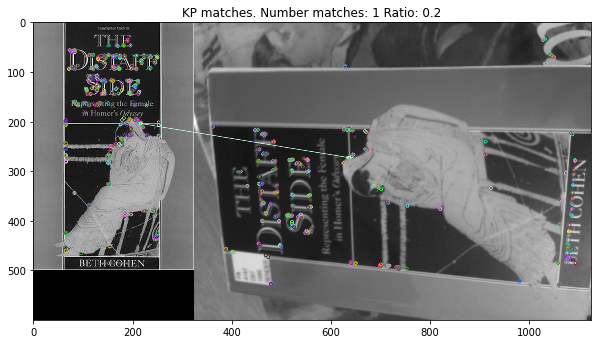

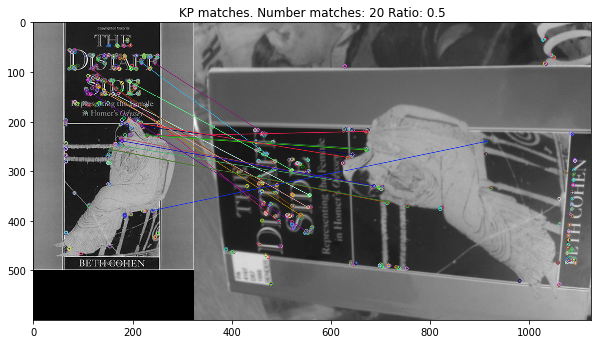

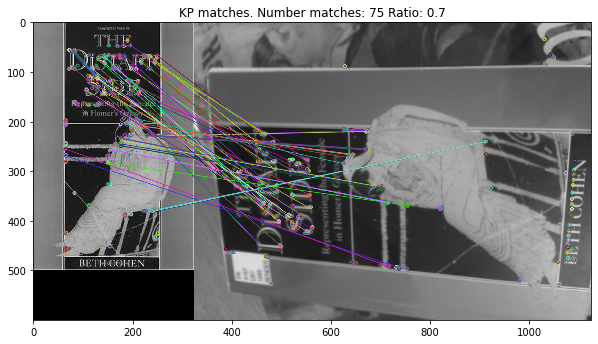

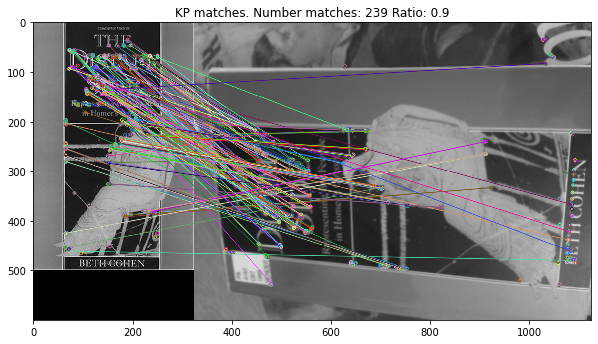

In [ ]:
for ratio in [0.2, 0.5, 0.7, 0.9]:
  #Calculate good matches
  good = match_features(des1, des2, ratio)
  # draw matches
  img_match = cv2.drawMatchesKnn(img1_draw_kp, kp1, img2_draw_kp, kp2, np.array([good]), None)
  plot_figure(img_match, "KP matches. Number matches: " + str(len(good)) + " Ratio: " + str(ratio))

**Analysis:**

We can see that when we increase the ratio used for the ratio test the number of matches between the query and reference image increases. This is because threshold for a match between the reference and query image to occur lowers as the ratio increases.

3. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

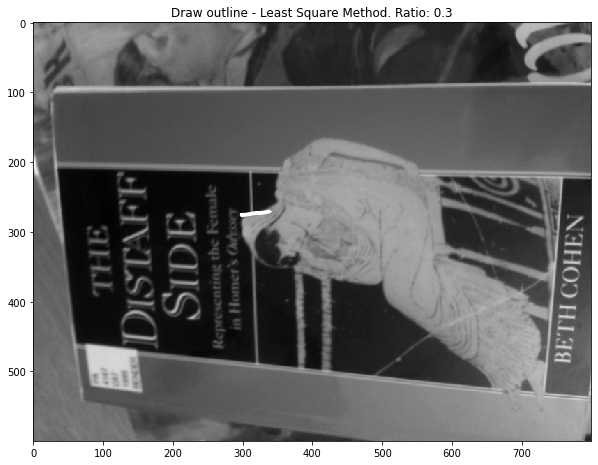

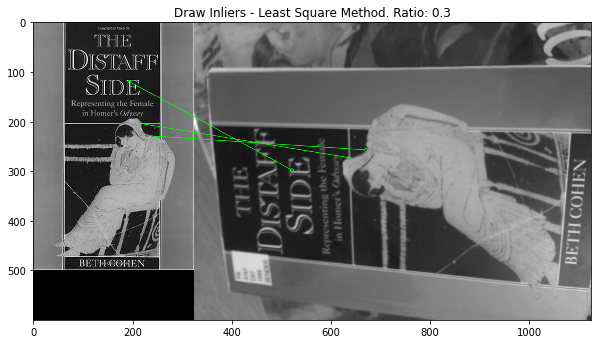

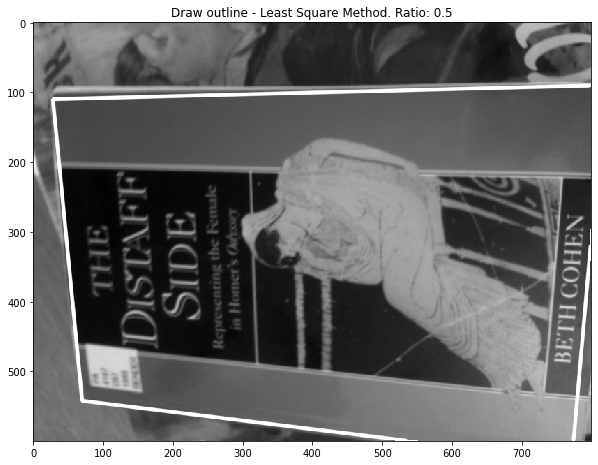

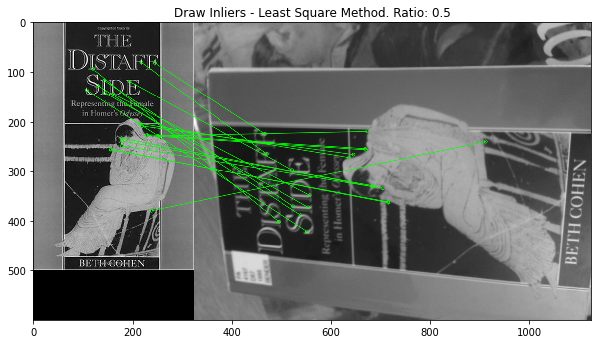

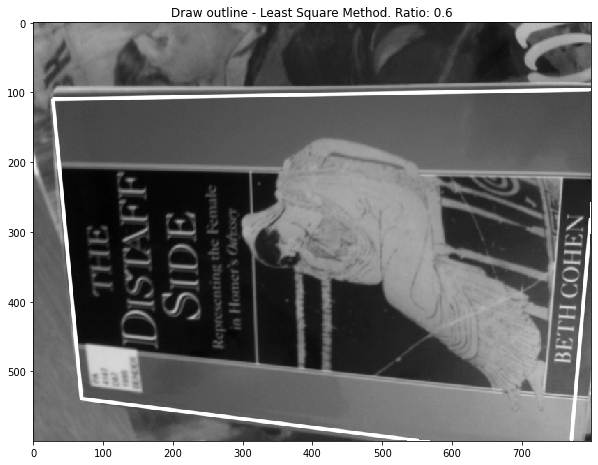

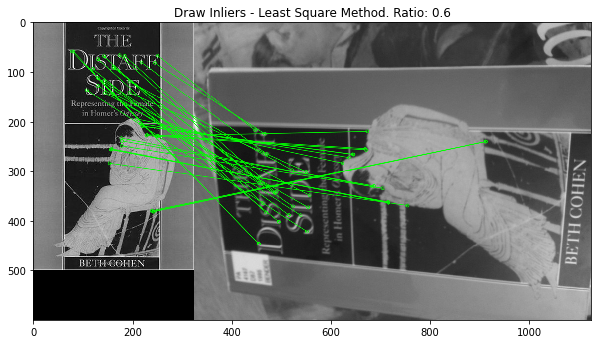

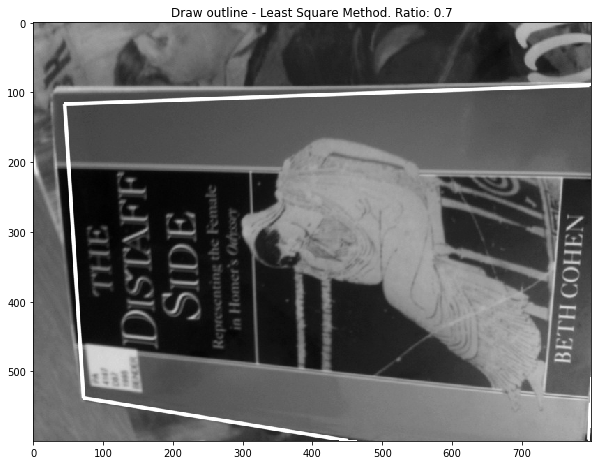

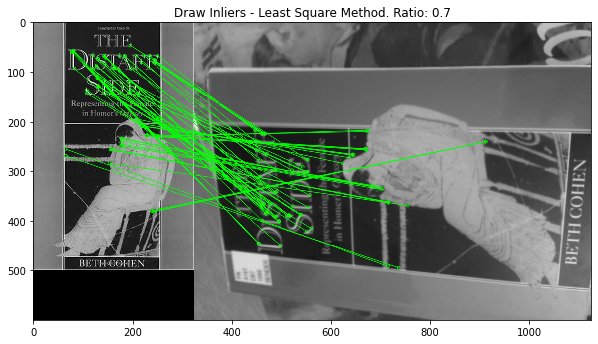

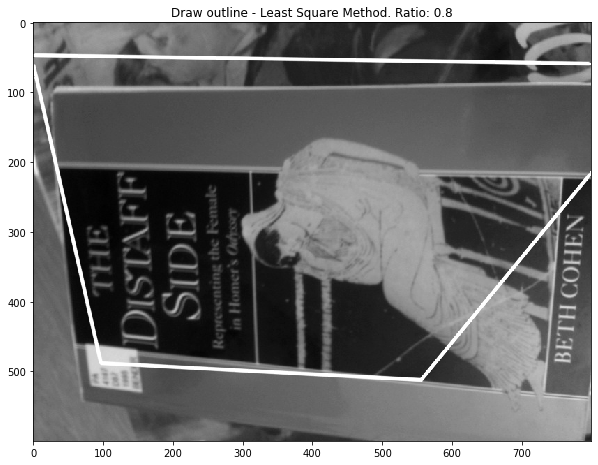

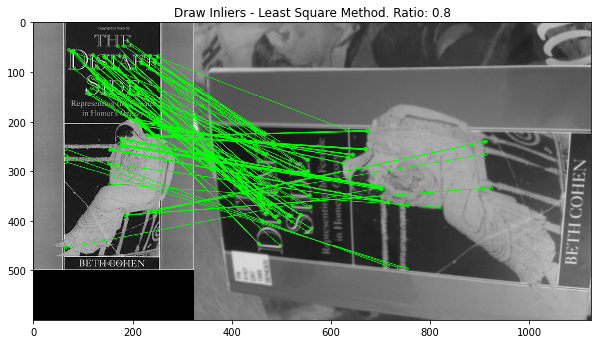

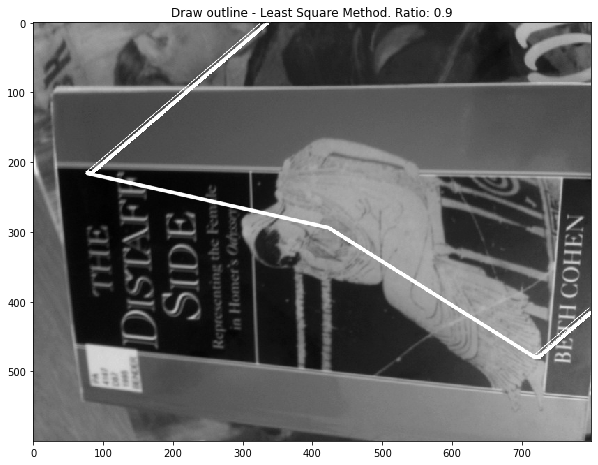

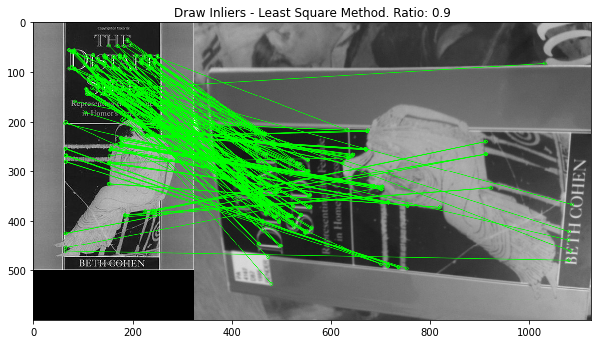

In [ ]:
# Your code to display book location here
for ratio in [0.3, 0.5, 0.6, 0.7, 0.8, 0.9]:
  #Calculate good matches
  good = match_features(des1, des2, ratio)

  # using regular method (cv2.findHomography)
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

  # Compute homography
  M, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)

  # draw outline and inliers
  draw_outline(img1, img2, M, "Draw outline - Least Square Method. Ratio: " + str(ratio))
  draw_inliers(img1, img2, kp1, kp2, good, mask, "Draw Inliers - Least Square Method. Ratio: " + str(ratio))

**Analysis**

We can see that with the least square method the query and reference image matches well with a ratio from 0.5 to 0.7. Most of the reference image is outlined in the query image. For lower ratios such as 0.3 we can see we don't have enough matches to draw a square. For higher ratios such as 0.9 we can see that too many matches have occured which has skewed the drawing of the outline.

Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers. Hint: use cv2.RANSCA with cv2.findHomography.


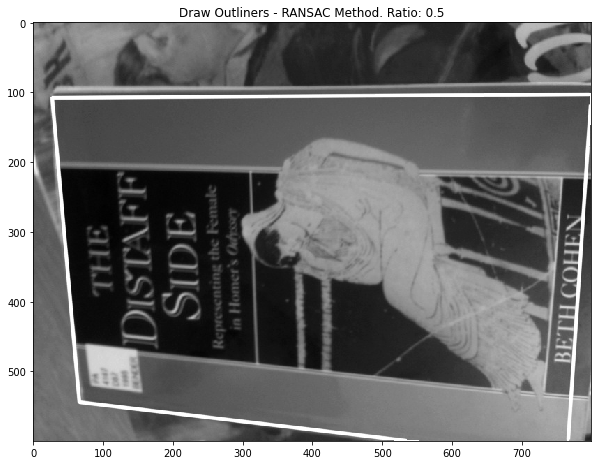

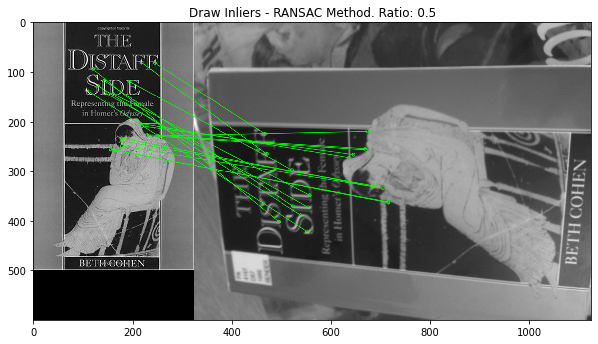

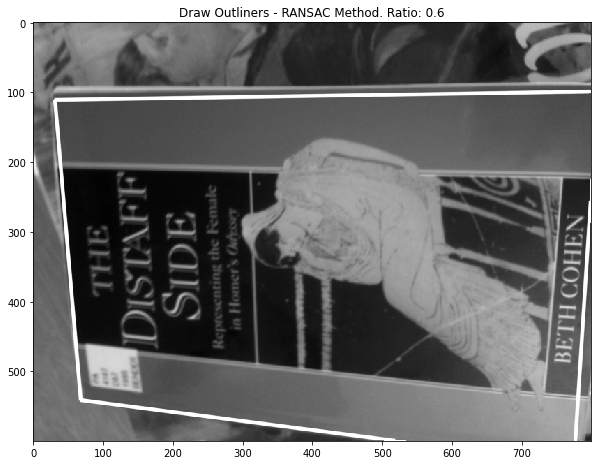

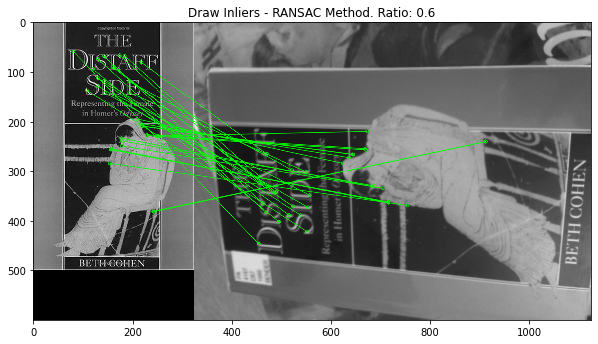

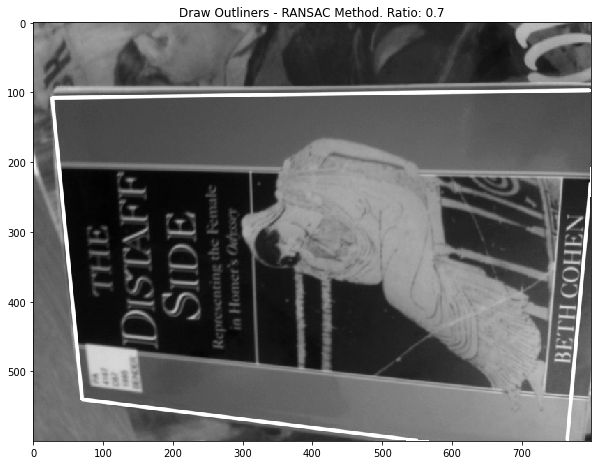

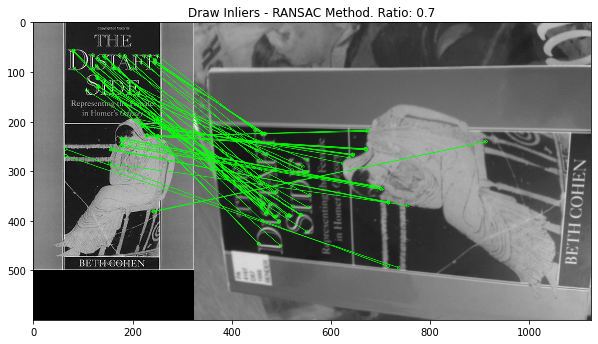

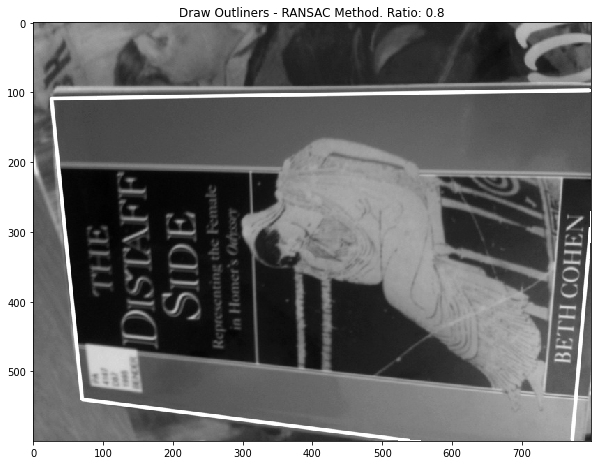

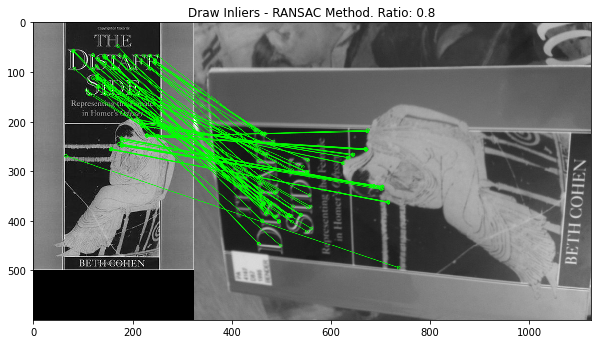

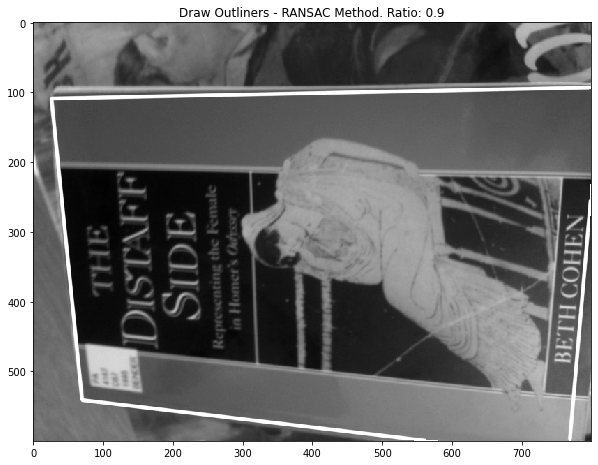

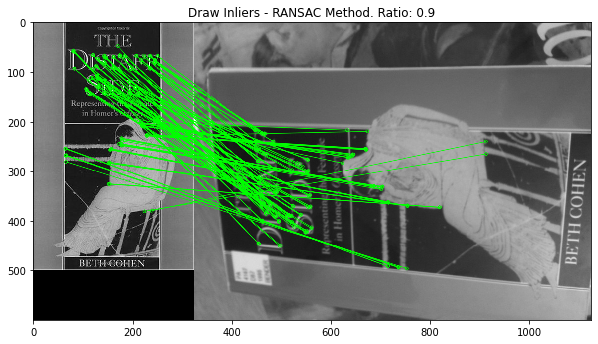

In [ ]:
# Your code to display book location after RANSAC here
for ratio in [0.5, 0.6, 0.7, 0.8, 0.9]:
  #Calculate good matches
  good = match_features(des1, des2, ratio)

  # using regular method (cv2.findHomography)
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

  # Compute homography
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  # draw outline and inliers
  draw_outline(img1, img2, M, "Draw Outliers - RANSAC Method. Ratio: " + str(ratio))
  draw_inliers(img1, img2, kp1, kp2, good, mask, "Draw Inliers - RANSAC Method. Ratio: " + str(ratio))

***Your explanation of what you have tried, and results here***

When using the RANSAC method to compute homography we can see better results compared to the least square method. We can see the outlines cover the reference image within the query. Another note is that for higher ratios such as 0.8 and 0.9 the reference image is still correctly outlined in the query image. When using the least square method we could see the outline would cover a large portion of the query image which does not contain the reference image.

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

In [44]:
def test_q1_6():
  for i in range(0, 50):
    img1 = books_ref[i]
    img2 = books_query[i]

    kp1, des1 = compute_descriptors(img1)
    kp2, des2 = compute_descriptors(img2)

    img1_draw_kp = cv2.drawKeypoints(img1, kp1, np.array([]))
    img2_draw_kp = cv2.drawKeypoints(img2, kp2, np.array([]))

    good = match_features(des1, des2, 0.7)
    
    if len(good) > 10:
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      draw_outline(img1, img2, M, "Draw Outliners - RANSAC Method. Ratio: 0.7, Index: " + str(i+1))

Matches Index: 7, 29, 34

n_features in ORB: None

RANSAC method

Ratio Method

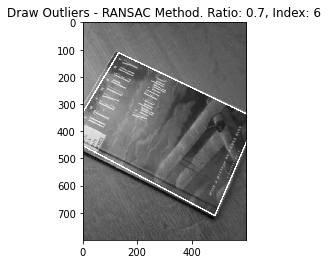

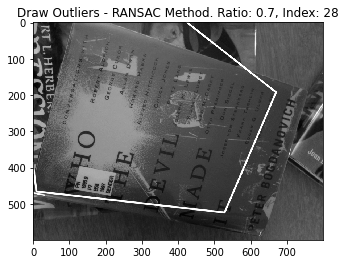

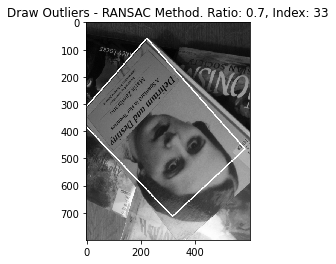

In [45]:
matches_index = [7, 29, 34]

for i in matches_index:
  i = i-1
  img1 = books_ref[i]
  img2 = books_query[i]

  kp1, des1 = compute_descriptors(img1)
  kp2, des2 = compute_descriptors(img2)

  img1_draw_kp = cv2.drawKeypoints(img1, kp1, np.array([]))
  img2_draw_kp = cv2.drawKeypoints(img2, kp2, np.array([]))

  good = match_features(des1, des2, 0.7)
  if len(good) > 10:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    draw_outline(img1, img2, M, "Draw Outliers - RANSAC Method. Ratio: 0.7, Index: " + str(i))

Matches Index: 7, 29, 34

n_features in ORB: 10,000

RANSAC method

Ratio Method

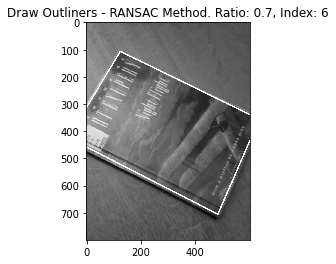

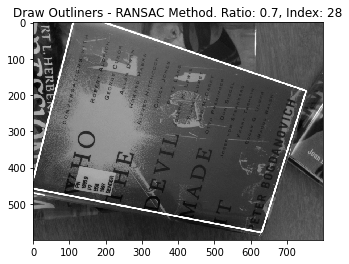

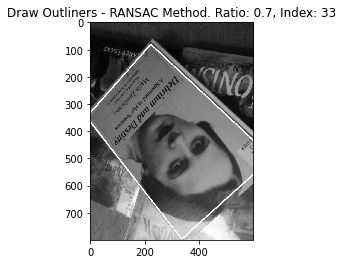

In [8]:
for i in matches_index:
  i = i-1
  img1 = books_ref[i]
  img2 = books_query[i]

  kp1, des1 = compute_descriptors(img1, 10000)
  kp2, des2 = compute_descriptors(img2, 10000)

  img1_draw_kp = cv2.drawKeypoints(img1, kp1, np.array([]))
  img2_draw_kp = cv2.drawKeypoints(img2, kp2, np.array([]))

  good = match_features(des1, des2, 0.7)
  if len(good) > 10:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    draw_outline(img1, img2, M, "Draw Outliners - RANSAC Method. Ratio: 0.7, Index: " + str(i))

***Your explanation of results here***

In the first set of images, image one works well with identifying outliers and image two and three can be improved upon. I chose the selected samples because I believe that improvements seen through changing the parameter settings would be seen clearly.

In the first set of images we decided to use the RANSAC method for findhomography since we saw it performs better than least square method. We also did not set the number of features in ORB. 

In the second set of images we still used the RANSAC method for findhomography since we saw it performs better than least square method. This time we set the number of features in ORB to 10,000 as suggested in the GitHub in q3. We can see that the draw_outline function greatly improves for the second and third image. This suggests that setting ORB to 10,000 will provide more accurate results.


# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hint 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [52]:
# Your code to identify query objects and measure search accuracy for data set here 
books_ref_des = []
books_ref_kp = []

books_query_des = []
books_query_kp = []

for img in books_ref:
  cur_kp, cur_ref = compute_descriptors(img, 2000)
  books_ref_des.append(cur_ref)
  books_ref_kp.append(cur_kp)

for img in books_query:
  cur_kp, cur_ref = compute_descriptors(img, 2000)
  books_query_des.append(cur_ref)
  books_query_kp.append(cur_kp)

In [56]:
num_correct = 0

for i, query in enumerate(books_query):
    max_score = -1
    max_idx = -1
    max_stats = []

    for j, ref in enumerate(books_ref):
        good = match_features(books_ref_des[j], books_query_des[i], 0.7)
        
        if len(good) > 5:
          M, mask = RANSAC_method(books_ref_kp[j], books_query_kp[i], good)
          score = len(mask.ravel().tolist())

          if max_score < score:
              max_idx = j + 1
              max_score = score
      
    if books_labels[i] == max_idx:
        print("Correct - Query image ", books_labels[i], " matches with reference image ", max_idx, "| Match Score: " + str(max_score))
        num_correct += 1
    else:
      print(" Incorrect - Query image ", books_labels[i], " matches with reference image ", max_idx, "| Match Score: " + str(max_score))

Correct - Query image  1  matches with reference image  1 | Match Score: 210
Correct - Query image  2  matches with reference image  2 | Match Score: 128
Correct - Query image  3  matches with reference image  3 | Match Score: 262
Correct - Query image  4  matches with reference image  4 | Match Score: 89
Correct - Query image  5  matches with reference image  5 | Match Score: 155
Correct - Query image  6  matches with reference image  6 | Match Score: 324
Correct - Query image  7  matches with reference image  7 | Match Score: 112
Correct - Query image  8  matches with reference image  8 | Match Score: 43
Correct - Query image  9  matches with reference image  9 | Match Score: 215
Correct - Query image  10  matches with reference image  10 | Match Score: 284
Correct - Query image  11  matches with reference image  11 | Match Score: 225
Correct - Query image  12  matches with reference image  12 | Match Score: 152
Correct - Query image  13  matches with reference image  13 | Match Scor

***Your explanation of what you have done, and your results, here***

In [57]:
print("Accuracy: ", num_correct / len(books_query) * 100, "%")

Accuracy:  90.0990099009901 %


We set the number of features in the ORB function to 
2,000 as it was determined that setting n_features to a high value is more effective in part 1.6. 

By not setting the number of features in the ORB function we returned an accuracy of 73.27%.

When setting the number of features in the ORB function to 1,000 we returned an accuracy of 81.2%.

When setting the number of features in the ORB function to 2,000 we returned an accuracy of 90.1%.

5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [46]:
num_correct = 0

for i, img1 in enumerate(books_query[0:80]):
    max_score = -1
    max_idx = -1

    for j, img2 in enumerate(books_ref[0:50]):
        good = match_features(books_ref_des[j], books_query_des[i], 0.7)
        
        if len(good) > 5:
          M, mask = RANSAC_method(books_ref_kp[j], books_query_kp[i], good)
          score = len(mask.ravel().tolist())

          if max_score < score:
              max_idx = j + 1
              max_score = score
    
    if max_score < 20:
      if i >= 50:
        print("Correct - Query image ", books_labels[i], "not in ref dataset and not matched | Max Score: ", str(max_score))
        num_correct += 1
      else:
        print("Incorrect - Query image ", books_labels[i], "in ref dataset and not matched | Max Score: ", str(max_score))
    else:
      if i >= 50:
        print("Incorrect - Query image ", books_labels[i], "not in ref dataset and matched with", str(max_idx), "| Max Score: ", str(max_score))
      elif max_idx == books_labels[i]:
        print("Correct - Query image ", books_labels[i], "in ref dataset and matched with", str(max_idx), "| Max Score: ", str(max_score))
        num_correct += 1
      elif max_idx != books_labels[i]:
        print("Incorrect - Query image ", books_labels[i], "in ref dataset and matched with", str(max_idx), "| Max Score: ", str(max_score))


Correct - Query image  1 in ref dataset and matched with 1 | Max Score:  210
Correct - Query image  2 in ref dataset and matched with 2 | Max Score:  128
Correct - Query image  3 in ref dataset and matched with 3 | Max Score:  262
Correct - Query image  4 in ref dataset and matched with 4 | Max Score:  89
Correct - Query image  5 in ref dataset and matched with 5 | Max Score:  155
Correct - Query image  6 in ref dataset and matched with 6 | Max Score:  324
Correct - Query image  7 in ref dataset and matched with 7 | Max Score:  112
Correct - Query image  8 in ref dataset and matched with 8 | Max Score:  43
Correct - Query image  9 in ref dataset and matched with 9 | Max Score:  215
Correct - Query image  10 in ref dataset and matched with 10 | Max Score:  284
Correct - Query image  11 in ref dataset and matched with 11 | Max Score:  225
Correct - Query image  12 in ref dataset and matched with 12 | Max Score:  152
Correct - Query image  13 in ref dataset and matched with 13 | Max Score

In [47]:
print("Accuracy: ", num_correct / 80 * 100, "%")

Accuracy:  96.25 %


***Your explanation of results and any changes made here***

I ran this experiment with a query dataset of 80 images and a reference dataset of 50 images.

When running this experiment with reference images not present in the query dataset I used the same refined parameters from q2.4. However, now that we are looking at images that may not be present in the dataset we need to determine an correct threshold to select when we think an image is not present.

The accuracy for this experiment is 96.25%


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [58]:
museum_ref_des = []
museum_query_des = []

museum_ref_kp = []
museum_query_kp = []

for img in museum_ref:
  cur_kp, cur_ref, = compute_descriptors(img, 2000)
  museum_ref_des.append(cur_ref)
  museum_ref_kp.append(cur_kp)

for img in museum_query:
  cur_kp, cur_ref, = compute_descriptors(img, 2000)
  museum_query_des.append(cur_ref)
  museum_query_kp.append(cur_kp)

In [63]:
num_correct = 0

for i, img1 in enumerate(museum_query[0:80]):
    max_score = -1
    max_idx = -1

    for j, img2 in enumerate(museum_ref[0:50]):
        good = match_features(museum_ref_des[j], museum_query_des[i], 0.7)
        
        if len(good) > 5:
          M, mask = RANSAC_method(museum_ref_kp[j], museum_query_kp[i], good)
          score = len(mask.ravel().tolist())

          if max_score < score:
              max_idx = j + 1
              max_score = score
    
    if max_score < 20:
      if i >= 50:
        print("Correct - Query image", museum_labels[i], "not in ref dataset and not matched | Max Score: ", str(max_score))
        num_correct += 1
      else:
        print("Incorrect - Query image", museum_labels[i], "in ref dataset and not matched | Max Score: ", str(max_score))
    else:
      if i >= 50:
        print("Incorrect - Query image", museum_labels[i], "not in ref dataset matched with", str(max_idx), "| Max Score: ", str(max_score))
      elif max_idx == museum_labels[i]:
        print("Correct - Query image", museum_labels[i], "in ref dataset and matched with", str(max_idx), "| Max Score: ", str(max_score))
        num_correct += 1
      elif max_idx != museum_labels[i]:
        print("Incorrect - Query image", museum_labels[i], "in ref dataset and matched with", str(max_idx), "| Max Score: ", str(max_score))

Correct - Query image 1 in ref dataset and matched with 1 | Max Score:  136
Incorrect - Query image 2 in ref dataset and not matched | Max Score:  13
Correct - Query image 3 in ref dataset and matched with 3 | Max Score:  55
Correct - Query image 4 in ref dataset and matched with 4 | Max Score:  24
Incorrect - Query image 5 in ref dataset and not matched | Max Score:  12
Correct - Query image 6 in ref dataset and matched with 6 | Max Score:  30
Correct - Query image 7 in ref dataset and matched with 7 | Max Score:  212
Correct - Query image 8 in ref dataset and matched with 8 | Max Score:  435
Incorrect - Query image 9 in ref dataset and not matched | Max Score:  17
Correct - Query image 10 in ref dataset and matched with 10 | Max Score:  151
Correct - Query image 11 in ref dataset and matched with 11 | Max Score:  104
Correct - Query image 12 in ref dataset and matched with 12 | Max Score:  240
Incorrect - Query image 13 in ref dataset and not matched | Max Score:  9
Correct - Query i

In [64]:
print("Accuarcy: ", num_correct / 80 * 100, "%")

Accuarcy:  61.25000000000001 %


***Your description of what you have done, and explanation of results, here***

I ran this experiment with a query dataset of 80 images and a reference dataset of 50 images.

When running this experiment with reference images not present in the query dataset I used the same refined parameters from q2.4. However, now that we are looking at images that may not be present in the dataset we need to determine an correct threshold to select when we think an image is not present.

The accuracy for this run was 61.25%. This is a 30% drop in accuracy compared to the book dataset. This could be occuring since the features of images from the book dataset are much easier to identify than the features of images in the museum dataset.

# Question 3 (10%)

In Question 1, We hope that `ratio_test` can provide reasonable results for RANSAC. However, if it fails, the RANSAC may not get good results. In this case, we would like to try an improved matching method to replace the `ratio_test`. Here, the `gms_matcher` is recommened. You need to implement it and save results of 3 image pairs (you can select any image pairs from the dataset),
where you new method is better than 'ratio_test'.


1. Hint 1: `cv2.xfeatures2d.matchGMS()` can be used, but you need to install the opencv-contrib by `pip install opencv-contrib-python`
2. Hint 2: You do not need use KNN matching, because GMS does not require second nearest neighbor.
3. Hint 3: You need to change the parameters in `cv2.ORB_create()` for best results. See the setting in Github.
4. Hint 4: If your are interested in more details. Read the paper "GMS: Grid-based Motion Statistics for Fast, Ultra-robust Feature Correspondence", and the Github "https://github.com/JiawangBian/GMS-Feature-Matcher".

***Your results here***

In [43]:
#Test all images in landmark dataset to determine possible instances where GMS works better than ratio test

def test_q3():
  for i in range(len(landmarks_query)):
    img1 = landmarks_ref[i]
    img2 = landmarks_query[i]

    orb = cv2.ORB_create(20000)
    orb.setFastThreshold(0)

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches_all = matcher.match(des1, des2)

    #Gms test matchs
    matches_gms = cv2.xfeatures2d.matchGMS(img1.shape, img2.shape, kp1, kp2, matches_all, withScale=False, withRotation=False, thresholdFactor=6)

    #Ratio test matches
    good_ratio = match_features(des1, des2, 0.7)
    
    plot_figure(img1, "Reference for image index " + str(idx))


    if len(matches_gms) > 5 and len(good) > 5:
      # GMS
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches_gms ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches_gms ]).reshape(-1,1,2)
      M, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
      draw_outline(img1, img2, M, "Draw Outliers - GMS Matches. Index: " + str(idx))

      # RANSAC
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_ratio ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_ratio ]).reshape(-1,1,2)
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
      draw_outline(img1, img2, M, "Draw Outliers - Ratio Method. Index: " + str(idx[i]))
    


Image pairs where GMS Matching is better than RANSAC.

I used the landmark dataset and identified images 9, 20 and 79 as images where the GMS method worked better than the ratio test method. In each of these images the GMS method is able to capture the features of the reference image in the query image better than the ratio method.

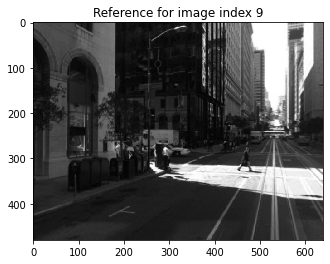

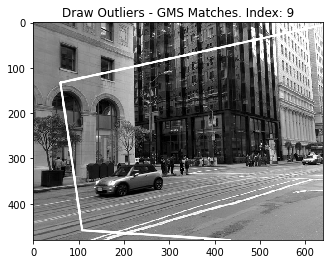

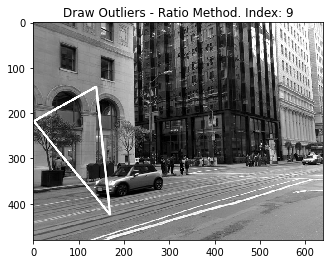

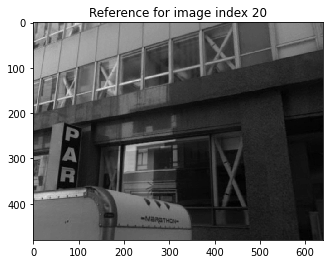

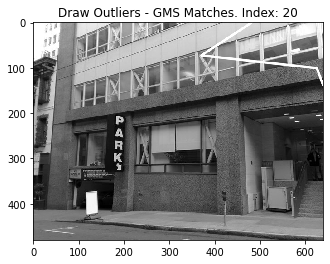

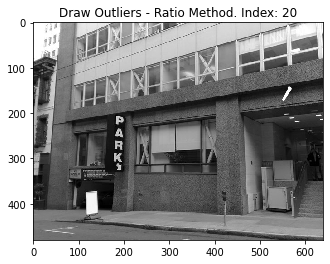

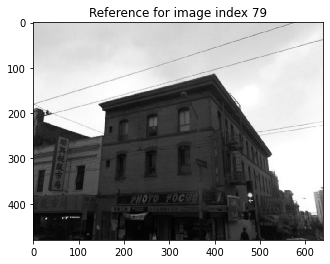

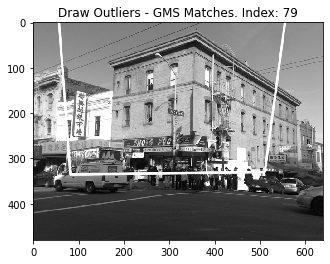

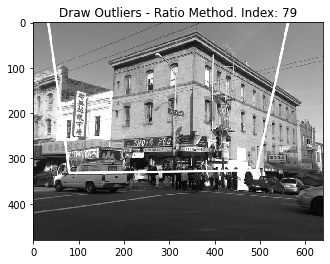

In [42]:
landmarks_idx = [9, 20, 79]

for idx in landmarks_idx:
  img1 = landmarks_ref[idx-1]
  img2 = landmarks_query[idx-1]
  
  orb = cv2.ORB_create(20000)
  orb.setFastThreshold(0)

  kp1, des1 = orb.detectAndCompute(img1, None)
  kp2, des2 = orb.detectAndCompute(img2, None)

  matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches_all = matcher.match(des1, des2)

  #Gms test matchs
  matches_gms = cv2.xfeatures2d.matchGMS(img1.shape, img2.shape, kp1, kp2, matches_all, withScale=False, withRotation=False, thresholdFactor=6)

  #Ratio test matches
  good_ratio = match_features(des1, des2, 0.7)

  plot_figure(img1, "Reference for image index " + str(idx))

  # GMS
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches_gms ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches_gms ]).reshape(-1,1,2)
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
  draw_outline(img1, img2, M, "Draw Outliers - GMS Matches. Index: " + str(idx))

  # RANSAC
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_ratio ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_ratio ]).reshape(-1,1,2)
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
  draw_outline(img1, img2, M, "Draw Outliers - Ratio Method. Index: " + str(idx))

# Question 4: Reflection Questions (5%)

1. Describe the hardest situation you faced during the first two assignments. And how you overcome it? (3%)

My hardest situation so far has been debugging issues with pip install. I was using a localhost enviornment for the assignments. In the second assignment I faced issues with installing the opencv-contrib library. I spent a lot of time debugging the issue with no avail. I overcame this by asking my peers for help. A peer came with a simple fix of using google colab to finish assignment 2, which resolved my issues.



2. How do you plan to finish the assignment to meet tight deadline? (2%)

When starting an assignment with a tight deadline I set out blocks of time in my schedule to work on the assignment. This helps to keep myself accountable with my time, and ensure that the assignment is not left last minute. I also set a few checkpoints to complete a certain amount of work by a specific date. This is so the assignment is not left until the last few days before the due date.
